In [3]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [4]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [5]:
downloaded = drive.CreateFile({'id':"18oUnJozgxW-l_Cs5qcqcReoP0sy5FJhN"})
downloaded.GetContentFile('train.csv')

downloaded = drive.CreateFile({'id':"1hseTPdsoTl4X3CPPVNpGQ9wUK2_nYzup"})
downloaded.GetContentFile('test.csv')

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mpl_toolkits
from scipy.stats import norm
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report, plot_confusion_matrix, \
                            roc_curve, auc, precision_recall_curve, \
                            mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats
import statsmodels.api as sm

In [7]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

#Exploring Data

Firstly I would like to explore our target variable "Sale Price"

In [8]:
train['SalePrice'].describe()

count       500.00000
mean     174635.21000
std       70251.34354
min       34900.00000
25%      127750.00000
50%      156000.00000
75%      207125.00000
max      446261.00000
Name: SalePrice, dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


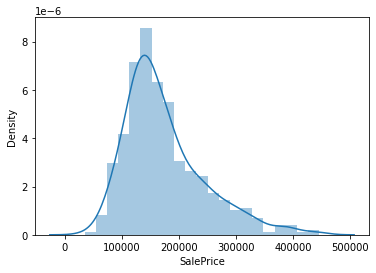

In [9]:
sns.distplot(train['SalePrice']);

In [10]:
print("Skewness: %f" % train['SalePrice'].skew())
print("Kurtosis: %f" % train['SalePrice'].kurt())

Skewness: 1.168351
Kurtosis: 1.382769


We see here that data is not perfectly normal distributed so apparently we will need to try taking natural logarithm of the variable.

In [11]:
corr_matrix = train.corr()
corr_matrix['SalePrice'].sort_values(ascending = False)

SalePrice       1.000000
OverallQual     0.776961
LivAreaSF       0.633778
GarageCars      0.619622
GarageArea      0.595167
YearBuilt       0.553303
YearRemodAdd    0.545892
X1stFlrSF       0.537493
FullBath        0.531140
GarageYrBlt     0.527794
TotRms          0.516113
Fireplaces      0.447948
BsmtSF          0.322246
X2ndFlrSF       0.312279
HalfBath        0.281591
LotArea         0.239929
Bedrooms        0.164637
MoSold          0.106637
PoolArea        0.067514
Id              0.005493
YrSold         -0.001794
LowQualSF      -0.023649
Type           -0.034614
OverallCond    -0.081883
Kitchen        -0.138246
Name: SalePrice, dtype: float64

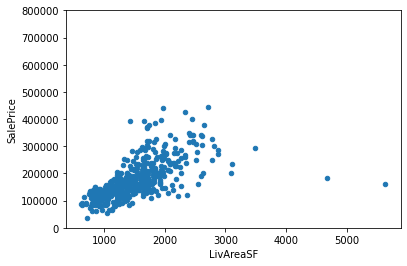

In [12]:
var = 'LivAreaSF'

data = pd.concat([train['SalePrice'], train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

It seems there are some outliers which we can eliminate.

In [13]:
train.sort_values(by = 'LivAreaSF', ascending = False)[:2]

,Id,Type,Zone,LotArea,LotConfig,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtRating,BsmtSF,CentralAir,X1stFlrSF,X2ndFlrSF,LowQualSF,LivAreaSF,FullBath,HalfBath,Bedrooms,Kitchen,KitchenQual,TotRms,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PoolArea,MoSold,YrSold,SaleCondition,SalePrice
3,1299,60,RL,63887,Corner,1Fam,2Story,10,5,2008,2008,Hip,Ex,TA,PConc,Ex,TA,Gd,GLQ,5644,Y,4692,950,0,5642,2,1,3,1,Ex,12,Typ,3,Gd,Attchd,2008.0,Fin,2,1418,TA,TA,480,1,2008,Abnorml,160000
51,524,60,RL,40094,Inside,1Fam,2Story,10,5,2007,2008,Hip,Ex,TA,PConc,Ex,TA,Gd,GLQ,2260,Y,3138,1538,0,4676,3,1,3,1,Ex,11,Typ,1,Gd,Other,2007.0,Fin,3,884,TA,TA,0,10,2007,Abnorml,184750


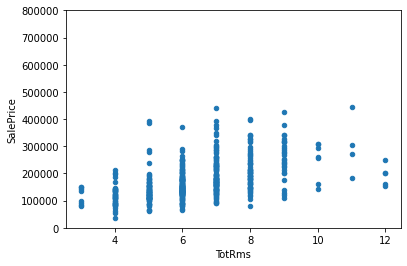

In [14]:
var = 'TotRms'

data = pd.concat([train['SalePrice'], train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

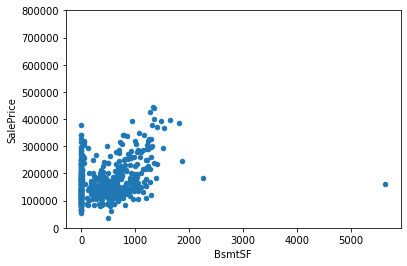

In [15]:
var = 'BsmtSF'

data = pd.concat([train['SalePrice'], train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

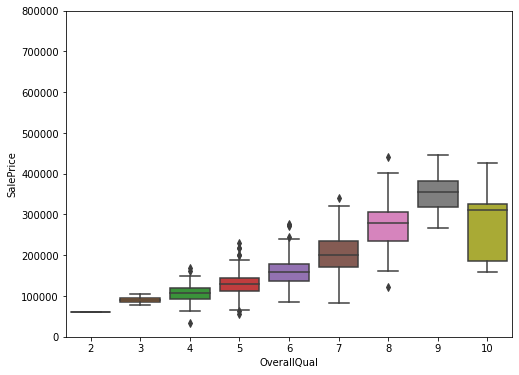

In [16]:
var = 'OverallQual'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

We see some trend here, which is logical.

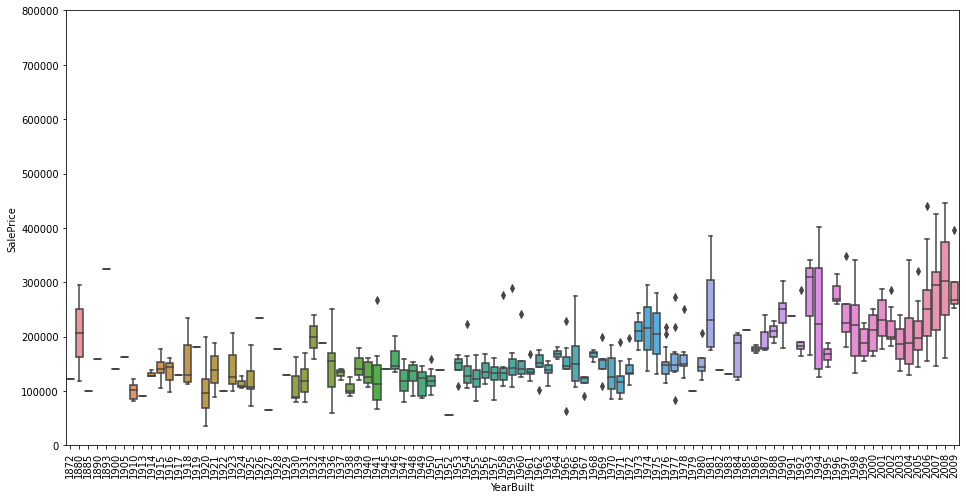

In [17]:
var = 'YearBuilt'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);
plt.xticks(rotation=90);

Trend here is much less visible but still it seems that newly built houses worth more.

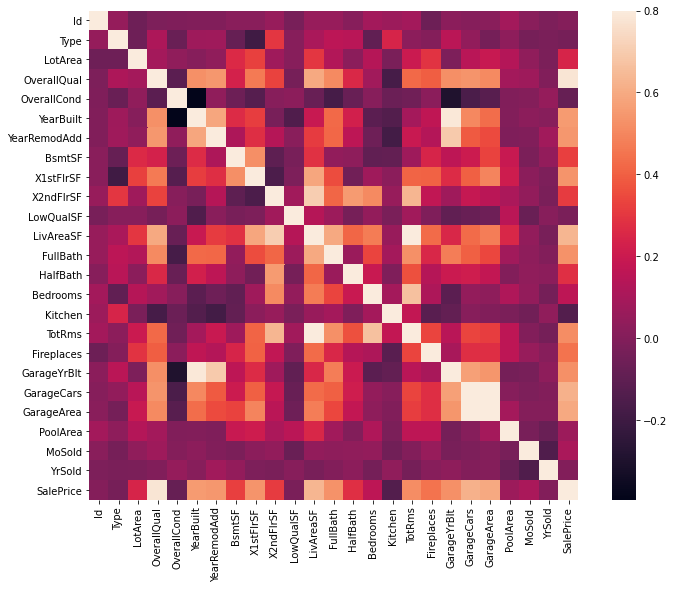

In [18]:
corrmat = train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

We can see here that there is high correlation between several variables, especially between GarageCars and GarageYrBlt as well as GarageYrBlt and Year Built. Moreover it also seems that number of TotRms is highly correlated with LivAreaSF. We need to take into consideration this fact and choose one of highly correlated variables from each pair.

Let's see what is exact colleration of the variables which are mostly correlated with our target variable.

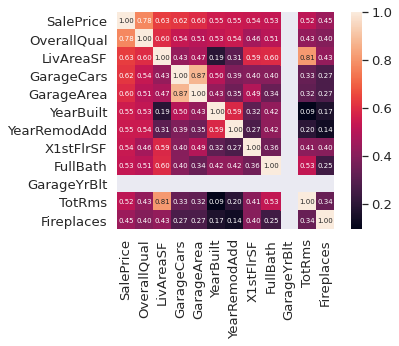

In [19]:
k = 12 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.2)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 7}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

Let's have a scatterplot of the variables that are correlated with our target variable the most. At the same I am taking into consideration the presence of multicollinearity and elimanate of the highly correlated variables from each pair. 

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:1969: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


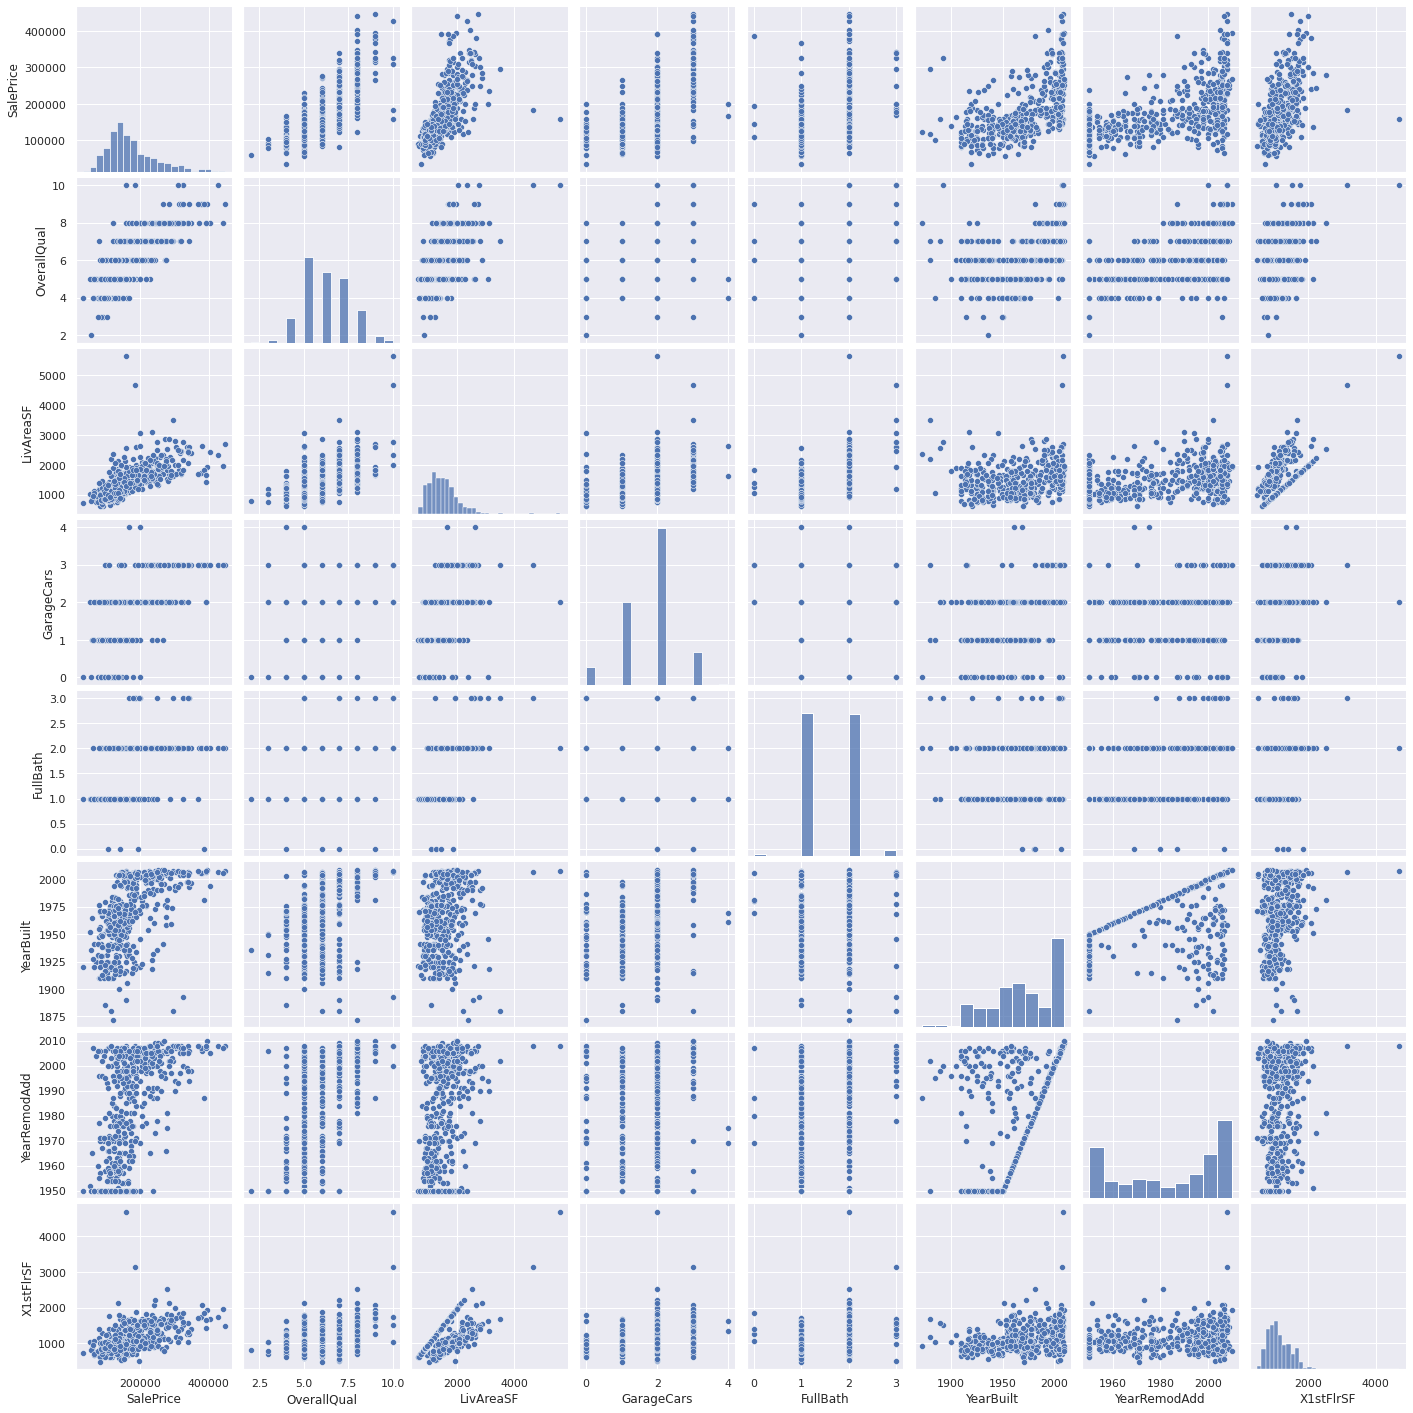

In [20]:
#scatterplot
sns.set()
cols = ['SalePrice', 'OverallQual', 'LivAreaSF', 'GarageCars', 'FullBath', 'YearBuilt', 'YearRemodAdd', 'X1stFlrSF']
sns.pairplot(train[cols], size = 2.5)
plt.show();

From this graph we can see that there exists a well emphasized trend of several variables associated with Sale Price. These variables are highly rated as they can explain our target variable in the most efficient way.

Now let's check what's going on with missing values.

In [21]:
total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
FireplaceQu,243,0.486
GarageCond,31,0.062
GarageQual,31,0.062
GarageFinish,31,0.062
GarageYrBlt,31,0.062
GarageType,31,0.062
BsmtRating,12,0.024
BsmtExposure,12,0.024
BsmtCond,12,0.024
BsmtQual,12,0.024


As one can see, there are some missing values that should be taken care of. After examining the data I found out that those are not missing values but values indicating an absence of particular variable in the house (ex. No fireplace is indicated as NA). I will take care of that later.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


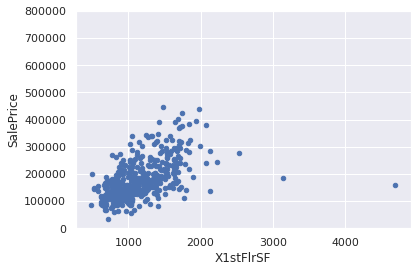

In [22]:
var = 'X1stFlrSF'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


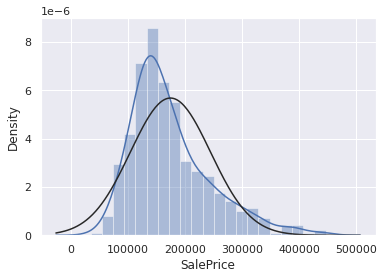

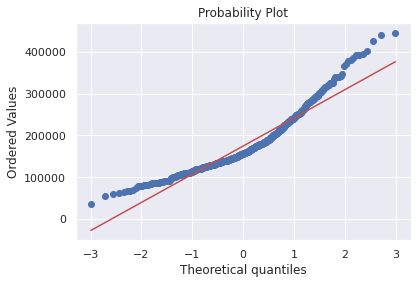

In [23]:
sns.distplot(train['SalePrice'], fit=norm);
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)

We see here that we need normalization of the variable. I will continue the same exploration to check if there is a need to do it for other variables as well.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


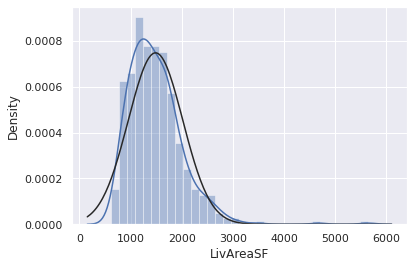

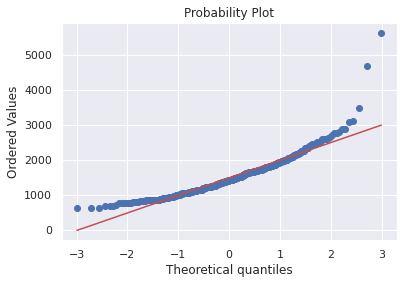

In [24]:
#histogram and normal probability plot
sns.distplot(train['LivAreaSF'], fit=norm);
fig = plt.figure()
res = stats.probplot(train['LivAreaSF'], plot=plt)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


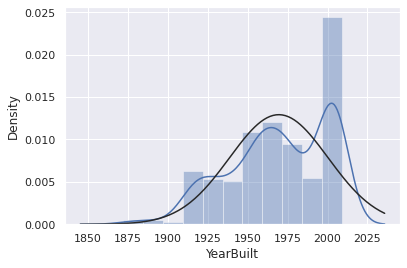

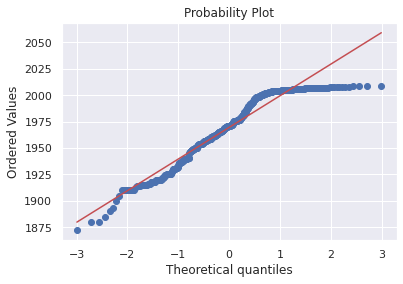

In [25]:
#histogram and normal probability plot
sns.distplot(train['YearBuilt'], fit=norm);
fig = plt.figure()
res = stats.probplot(train['YearBuilt'], plot=plt)

#Preprocessing

Here I set up RMSLE scoring formula which I will use later on.

In [26]:
def RMSLE(y_true, y_pred):
  mn = (np.mean(np.sum((np.log(y_true)- np.log(y_pred))**2)))**(1/2)
  return mn

def MAPE(y_true, y_pred): 
  mn = np.mean(np.abs((y_true-y_pred)/y_true))
  return mn

The whole preprocessing of the data is done through the below function where I use different functions within another funtion to quickly preprocess both train and test data. 

In [27]:
def fill_na_by_value(df, col: str , value_to_replace: str):
  df[col]= df[col].fillna(value_to_replace)

def get_ratio(df, ratio_name, numerator, denominator):
  df[ratio_name] = df[numerator]/df[denominator]

def get_diff(df, dif_name, first, second):
  df[dif_name] = df[first] - df[second]

def get_interaction(df, feature1, feature2):
  df['{}*{}'.format(feature1, feature2)] = df[feature1]*df[feature2]

def preprocess_data(df, is_train = True):
  df_temp_tot = df.copy()

  for i in dict_to_replace_values:
    df_temp_tot[i] = df_temp_tot[i].apply(str)
    
  for i in dict_to_replace_na.keys():
    fill_na_by_value(df_temp_tot, i, dict_to_replace_na[i])

  #adding more variables
  df_temp_tot['Tot_surf'] = df_temp_tot['BsmtSF'] + df_temp_tot['X1stFlrSF'] + df_temp_tot['X2ndFlrSF']
  df_temp_tot['Total_bath'] = df_temp_tot['FullBath'] + 0.5*df_temp_tot['HalfBath'] 

  for i in dict_to_log:
    df_temp_tot[i] = np.log(df_temp_tot[i])

  for i in dict_to_sqrt:
    df_temp_tot[i] = np.sqrt(df_temp_tot[i])

  for i in dict_to_replace_cat:
    df_temp_tot[i] = df_temp_tot[i].map(mapping_ex)

  #Replacing more categorical variables
  df_temp_tot['Functional'] = df_temp_tot['Functional'].map(mapping_func)
  df_temp_tot['BsmtExposure'] = df_temp_tot['BsmtExposure'].map(mapping_exposure)

  df_temp_num = df_temp_tot[numerical]
  
  for i in ratio_dict.keys():
    get_ratio(df_temp_num, i, ratio_dict[i]['numerator'], ratio_dict[i]['denominator'])

  for i in diff_dict.keys():
    get_diff(df_temp_num, i, diff_dict[i]['first'], diff_dict[i]['second'])

  df_temp_x = pd.concat([df_temp_num, pd.get_dummies(df_temp_tot[categorical], drop_first = True)], axis = 1)
  
  for i in interactions_features:
    get_interaction(df_temp_x, i[0], i[1])
  
  df_temp_x = df_temp_x.drop([
                              'Kitchen', 
                              'TotRms', 
                              'Type_75',
                              'Type_20',
                              'Type_80',
                              'Type_85',
                              'Type_190',
                              'Type_40',
                              'Type_180',
                              'Type_160',
                              'Type_60',
                              'Type_30',
                              'Type_45',
                              'SaleCondition_Abnorml',
                              'SaleCondition_Family',
                              'YrSold',
                              'YearBuilt',
                              'YearRemodAdd',
                              'SaleCondition_Normal',
                              ] ,axis=1, errors='ignore')

  if is_train:
    df_temp_y = np.log(df_temp_tot['SalePrice'])
    #deleting the outliers
    df_temp_y = df_temp_y.drop([3, 51])
    df_temp_x = df_temp_x.drop([3, 51]).reset_index()
    df_temp_x = df_temp_x.reset_index(drop=True)
    df_temp_y = df_temp_y.reset_index(drop=True)
  else:
    return df_temp_x
  return df_temp_x, df_temp_y

In [28]:
dict_to_replace_na = {'FireplaceQu': 'Na', 
                      'BsmtQual':'Na', 'BsmtCond':'Na',
                      'BsmtExposure':'Na','BsmtRating':'Na', 'GarageType':'No garage', 
                      'GarageFinish': 'No garage', 'GarageQual':'Na'}

dict_to_replace_values = ['Type', 'Zone',]

#didn't use ratios in the end, but decided to keep the dictionary
#for further possible usage.
ratio_dict = {
              # 'area_per_room': {'numerator': 'LivAreaSF', 'denominator': 'TotRms'},
              # 'kitchen_per_room':{'numerator': 'Kitchen', 'denominator': 'TotRms'},
              # 'baths_per_1stroom': {'numerator': 'FullBath', 'denominator': 'X1stFlrSF'}
              }

dict_to_log = ['X1stFlrSF']

dict_to_sqrt = ['LivAreaSF', 'LotArea']

diff_dict = {'Age': {'first': 'YrSold', 'second': 'YearBuilt'},
             'AgeMod': {'first': 'YrSold', 'second': 'YearRemodAdd'}}

#didn't use interaction terms in the end, but decided to keep the dictionary
#for further possible usage.
interactions_features = [
                         #('SaleCondition_Normal', 'OverallQual')
                         ]

dict_to_replace_cat = ['BsmtQual', 'BsmtCond', 'GarageQual', 'FireplaceQu', 'KitchenQual']    
mapping_ex = {'Ex': 5, 'Gd': 4, "TA": 3, "Fa": 2, "Po": 1, "Na": 0}
mapping_zone = {'C': 4, 'FV': 3, 'RH': 2, 'RL':1, 'RM':0}
mapping_func = {'Typ': 3, 'Min': 2, 'Mod':1, 'Maj':0}
mapping_exposure = {'Gd': 4, 'Av': 3, 'Mn': 2, 'No':1, 'Na':0}

Below is the list of the all the available variables. I commented those that I didn't want to use. Remaining columns are used in the model.

In [29]:
numerical = [
             'BsmtExposure', 
             'KitchenQual', 
             'OverallCond', 
            #  'Total_bath',
            #  'Tot_surf',
            #  'FireplaceQu',
            #  'GarageQual',
             'OverallQual',
             'LotArea', 
             'YearBuilt',
             'BsmtQual', 
            #  'BsmtCond',
             'YearRemodAdd', 
             'BsmtSF', 
              'X1stFlrSF', 
            #  'X2ndFlrSF', 
            #  'LowQualSF',
             'LivAreaSF', 
            #  'FullBath', 
            #  'HalfBath', 
            #  'Bedrooms',  
            #  'Kitchen', 
            #  'TotRms',
             'Fireplaces', 
            # #  'GarageYrBlt',
            #  'GarageCars', 
             'GarageArea', 
            # #  'PoolArea', 
             'YrSold'
             ]

categorical = [
               'Functional', 
               'Zone',
              #  'Id',
              #  'Type', 
              #  'LotConfig', 
              #  'BldgType', 
              #  'HouseStyle',  
              #  'RoofStyle', 
              #  'ExterQual', 
              #  'ExterCond',  
              #  'Foundation',
              #  'BsmtRating', 
              #  'CentralAir',  
              #  'GarageType', 
              #  'GarageFinish',
              #  'GarageCond', 
              #  'MoSold', 
               'SaleCondition'
               ]

Implementing preprocess of train and test data

In [30]:
X_train, y_train = preprocess_data(train)
X_test = preprocess_data(test, False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Since there are some columns which are missing from test data, I am making sure that only those columns that are available in two datasets are used.

In [31]:
cols_to_keep = set(X_test.columns) & set(X_train.columns)
X_train = X_train[cols_to_keep]
X_test = X_test[cols_to_keep]

Below are the results of the regression. After many tests and trials I came up with the following model.

In [32]:
results = sm.OLS(y_train, X_train).fit(cov_type='HC1')

In [33]:
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:              SalePrice   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.999
Method:                 Least Squares   F-statistic:                          6.573e+04
Date:                Mon, 05 Jul 2021   Prob (F-statistic):                        0.00
Time:                        19:45:36   Log-Likelihood:                         -63.239
No. Observations:                 498   AIC:                                      162.5
Df Residuals:                     480   BIC:                                      238.3
Df Model:                          18                                                  
Covariance Type:                  HC1                                                  
                   coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------

#Modelling

In this section I am training my model, then by using cross validation I am testing whether the model is sufficiently good and finally make a prediction.

In [34]:
mdl = LinearRegression()
mdl.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Cross-validation

In [35]:
def get_metrics(specification, X_train, y_train, model, params = None):
  y_train_metrics = []
  y_test_metrics = []

  y_train_MAPE = []
  y_test_MAPE = []

  kf = KFold(n_splits=5, random_state= 100, shuffle = True)
  for train_index, test_index in kf.split(X_train):
    y_train_ = y_train[train_index]
    X_train_ = X_train.iloc[train_index, :]
    y_test_ = y_train[test_index]
    X_test_= X_train.iloc[test_index, :]

    if params is None:
      mdl = model()
    else:
      mdl = model(**params)
      
    mdl.fit(X_train_, y_train_)

    y_pred_train = mdl.predict(X_train_)
    y_pred_test = mdl.predict(X_test_)

    y_train_metrics.append(RMSLE(y_train_, y_pred_train))
    y_test_metrics.append(RMSLE(y_test_, y_pred_test))
    y_train_MAPE.append(MAPE(y_train_, y_pred_train))
    y_test_MAPE.append(MAPE(y_test_, y_pred_test))
  
  y_train_metrics = np.mean(y_train_metrics)
  y_test_metrics = np.mean(y_test_metrics)

  y_train_MAPE = np.mean(y_train_MAPE)
  y_test_MAPE = np.mean(y_test_MAPE)

  return specification, y_train_metrics, y_test_metrics, y_train_MAPE, y_test_MAPE

In [36]:
get_metrics('metrics with two ratios generated', X_train, y_train, LinearRegression)

('metrics with two ratios generated',
 0.20125796591611128,
 0.1076323433875648,
 0.0073069059786522676,
 0.007720586796308324)

The results are good and in order to check the overfit effect I am using the following curve

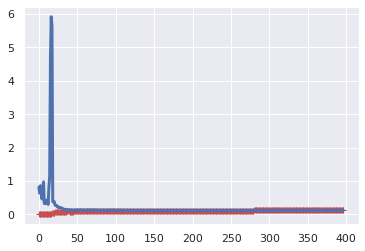

In [41]:
def plot_learning_curves(model, X, y):
  X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
  train_errors, val_errors = [], []
  for m in range(1, len(X_train)):
    model.fit(X_train[:m], y_train[:m])
    y_train_predict = model.predict(X_train[:m])
    y_val_predict = model.predict(X_val)
    train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
    val_errors.append(mean_squared_error(y_val, y_val_predict))
  plt.plot(np.sqrt(train_errors), "r-+", linewidth = 2, label = "train")
  plt.plot(np.sqrt(val_errors), "b-", linewidth =3, label="val")

plot_learning_curves(mdl, X_train, y_train)

As one can see the model is overfitting with low number of observations. As soon as the number of the observations is increasing, the overfit effect of the model is eliminated.

In [37]:
predict = np.exp(mdl.predict(X_test))

In [38]:
data = {'Id': test['Id'], 
        'SalePrice': predict}
final = pd.DataFrame(data)
final

,Id,SalePrice
0,115,222350.832413
1,1295,119237.904025
2,130,150259.889087
3,519,193250.815614
4,104,185162.051707
...,...,...
495,1029,125237.443149
496,805,115399.677664
497,703,314144.261379
498,110,212114.252357


In [39]:
final.to_csv(r'Submission.csv', index = False, header=True)